In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import random
import json
import gc

import numpy as np
import pandas as pd
import torch
import torchio as tio
import h5py
from ipywidgets import interact
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import nibabel as nib
from einops import rearrange
from scipy import ndimage
from fracridge import FracRidgeRegressorCV
from sklearn.model_selection import KFold


dir2 = os.path.abspath('../..')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: 
    sys.path.append(dir1)

In [2]:
dataset_path = Path('D:\\Datasets\\NSD\\')
derivatives_path = dataset_path / 'derivatives'
betas_path = dataset_path / 'nsddata_betas' / 'ppdata'
ppdata_path = dataset_path / 'nsddata' / 'ppdata'

In [3]:
subjects = {f'subj0{i}': {} for i in range(1, 9)}

for subject_name, subject_data in subjects.items():
    responses_file_path = ppdata_path / subject_name / 'behav' / 'responses.tsv'
    subject_data['responses'] = pd.read_csv(responses_file_path, sep='\t',)
    
    # The last 3 sessions are currently held-out for the algonauts challenge
    # remove them for now.
    session_ids = subject_data['responses']['SESSION']
    held_out_mask = session_ids > (np.max(session_ids) - 3)
    subject_data['responses'] = subject_data['responses'][~held_out_mask]
    
    subject_betas_path = derivatives_path / 'betas' / subject_name / 'func1pt8mm' / 'betas_fithrf_GLMdenoise_RR'
    num_sessions = np.max(subject_data['responses']['SESSION'])
    
    subject_data['betas'] = h5py.File(subject_betas_path / f'betas_sessions.hdf5', 'r')['betas']
    
    #subject_data['brainmask'] = nib.load(ppdata_path / subject_name / 'func1pt8mm' / 'brainmask.nii.gz')
    #subject_data['t1_path'] = ppdata_path / subject_name / 'func1pt8mm' / 'T1_to_func1pt8mm.nii.gz'

In [4]:
#embedding_model = 'ViT-B=32'
embedding_model = 'bigbigan-resnet50'

#embedding_key = 'embedding'
embedding_key = 'z_mean'

subject_name = 'subj01'

num_voxels = 2500

split_name = 'split-01'
split = h5py.File(derivatives_path / 'data_splits' / f'{split_name}.hdf5')
subject_split = split[subject_name]
test_mask = subject_split['test_response_mask'][:].astype(bool)
validation_mask = subject_split['validation_response_mask'][:].astype(bool)
validation_indices = np.where(validation_mask)[0]
training_mask = ~(test_mask | validation_mask)
training_indices = np.where(training_mask)[0]
responses = subjects[subject_name]['responses']
training_stimulus_ids = responses['73KID'].to_numpy()[training_indices] - 1
validation_stimulus_ids = responses['73KID'].to_numpy()[validation_indices] - 1

model_embeddings = h5py.File(derivatives_path / 'stimulus_embeddings' / f'{embedding_model}-embeddings.hdf5', 'r')
stimulus_embeddings = model_embeddings[embedding_key]

encoder_name = 'fracridge'
encoder_parameters = h5py.File(derivatives_path / f'{encoder_name}-parameters.hdf5', 'r')
sorted_indices_flat = encoder_parameters[subject_name][embedding_model][embedding_key]['sorted_indices_flat']

X = np.stack([
    subjects[subject_name]['betas'][:, i] 
    for i in sorted_indices_flat[:num_voxels]
], axis=1)
X = torch.from_numpy(X).float() / 300

X_train = X[training_indices]
X_val = X[validation_mask]

X_train_mean = X_train.mean(dim=0, keepdims=True)
X_train_std = X_train.std(dim=0, keepdims=True)
X_train = (X_train - X_train_mean) / X_train_std
X_val = (X_val - X_train_mean) / X_train_std

Y = stimulus_embeddings[:]
Y = torch.from_numpy(Y).float()
Y_train = Y[training_stimulus_ids]
Y_val = Y[validation_stimulus_ids]

In [5]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

(torch.Size([21750, 2500]),
 torch.Size([21750, 120]),
 torch.Size([3000, 2500]),
 torch.Size([3000, 120]))

In [6]:
from torch.utils.data import TensorDataset

dataset_training = TensorDataset(X_train, Y_train)
dataset_val = TensorDataset(X_val, Y_val)

In [76]:
from typing import Tuple, Optional, Dict

import torch
from torch import nn
import torch.nn.functional as F

from torch.optim import Adam
from torch.utils.data import DataLoader

from research.models.components_2d import BlurConvTranspose2d
from research.models.fmri_decoders import VariationalDecoder, SpatialDecoder, SpatialDiscriminator
from research.metrics.loss_functions import (
    EuclideanLoss, 
    EmbeddingClassifierLoss,
    ProbabalisticCrossEntropyLoss,
    VariationalLoss,
    CosineSimilarityLoss,
    EmbeddingDistributionLoss,
    ContrastiveCosineSimilarityLoss,
)
from research.metrics.metrics import cosine_similarity, pearsonr, embedding_distance

hidden_size = 5000
out_size = Y_train.shape[1]

model = VariationalDecoder(
    num_voxels, out_size, hidden_size, 
    #decoder_class=decoder_class,
    #decoder_params=decoder_params,
)

#model = nn.Sequential(
#    nn.Linear(in_features=num_features, out_features=hidden_size),
#    nn.LeakyReLU(),
#    torch.nn.Dropout(p=0.9, inplace=False),
#    nn.Linear(hidden_size, out_size),
#)

#criterion = ContrastiveCosineSimilarityLoss()
criterion = nn.MSELoss()
#criterion = CosineSimilarityLoss()
#riterion = nn.L1Loss()
criterion = VariationalLoss(distance_loss=criterion, kld_weight=1e-4,)

optimizer = Adam(
    params=[*model.parameters(), *criterion.parameters()],
    lr=1e-4
)

device = torch.device('cuda')
model.to(device)

VariationalDecoder(
  (decoder): Sequential(
    (0): Linear(in_features=2500, out_features=5000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.9, inplace=False)
    (3): Linear(in_features=5000, out_features=240, bias=True)
  )
)

In [78]:
# Variational training

training_dataloader = DataLoader(dataset_training, shuffle=True, batch_size=128)

def get_data_iterator(loader):
    while True:
        for batch in loader:
            yield batch
            
def run_all(dataset):
    return torch.cat([model(x.to(device)[None])[0] for x, _ in dataset]).cpu()

training_data_iterator = get_data_iterator(training_dataloader)

max_iterations = 1500
for i in range(max_iterations):
    x, y = next(training_data_iterator)
    x = x.to(device)
    y = y.to(device)

    model.train()
    y_pred, mu, log_var = model(x)
    loss, loss_dict = criterion(y, y_pred, mu, log_var)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model.eval()
    
    if i % 25 == 0:
        print({k: round(v.detach().cpu().item(), 3) for k, v in loss_dict.items()})
    
    if i % 250 == 0:
        model.eval()
        with torch.no_grad():
            Y_train_pred = run_all(dataset_training)
            Y_val_pred = run_all(dataset_val)
        
        print('2v2-cosine-dist', 
              two_versus_two(dataset_training.tensors[1], Y_train_pred, cosine_distance),
              two_versus_two(dataset_val.tensors[1], Y_val_pred, cosine_distance),)
        print('2v2-euclidean-dist', 
              two_versus_two(dataset_training.tensors[1], Y_train_pred, euclidean_distance),
              two_versus_two(dataset_val.tensors[1], Y_val_pred, euclidean_distance),)

{'loss': 0.663, 'distance_loss': 0.636, 'kld_loss': 0.027, 'kld': 271.457}
2v2-cosine-dist tensor(0.9972) tensor(0.9600)
2v2-euclidean-dist tensor(0.9972) tensor(0.9605)
{'loss': 0.651, 'distance_loss': 0.624, 'kld_loss': 0.027, 'kld': 271.768}
{'loss': 0.638, 'distance_loss': 0.612, 'kld_loss': 0.026, 'kld': 259.16}
{'loss': 0.644, 'distance_loss': 0.617, 'kld_loss': 0.027, 'kld': 269.696}
{'loss': 0.662, 'distance_loss': 0.636, 'kld_loss': 0.026, 'kld': 264.942}
{'loss': 0.657, 'distance_loss': 0.629, 'kld_loss': 0.028, 'kld': 276.638}
{'loss': 0.672, 'distance_loss': 0.645, 'kld_loss': 0.027, 'kld': 271.491}
{'loss': 0.639, 'distance_loss': 0.612, 'kld_loss': 0.027, 'kld': 270.181}
{'loss': 0.655, 'distance_loss': 0.628, 'kld_loss': 0.027, 'kld': 268.653}
{'loss': 0.645, 'distance_loss': 0.618, 'kld_loss': 0.027, 'kld': 270.583}
{'loss': 0.64, 'distance_loss': 0.614, 'kld_loss': 0.026, 'kld': 263.112}
2v2-cosine-dist tensor(0.9977) tensor(0.9609)
2v2-euclidean-dist tensor(0.9977) te

In [ ]:
from pathlib import Path

out_path = derivatives_path / 'decoded_features'

def run_all_variational(dataset):
    mean = []
    std = []
    for x, _ in dataset:
        _, mu, log_var = model(x.to(device)[None])
        mean.append(mu)
        std.append(torch.exp(0.5 * log_var))
    mean = torch.cat(mean)
    std = torch.cat(std)
    out = torch.stack([mean, std], dim=1)
    return out.detach().cpu().numpy()
        
Y_val_pred = run_all_variational(dataset_val)

version = '4-0'
code_name = 'sanitycheck'
out_dir = out_path / embedding_model / embedding_key / subject_name
out_dir.mkdir(parents=True, exist_ok=True)
np.save(out_dir / f'Y_val_pred__{code_name}__v{version}.npy', Y_val_pred)
np.save(out_dir / f'Y_val__{code_name}__v{version}.npy', Y_val)

In [72]:
from functools import partial

def euclidean_distance(Y1, Y2):
    Y1_squared = (Y1 ** 2).sum(dim=-1)
    Y2_squared = (Y2 ** 2).sum(dim=-1)
    Y1_dot_Y2 = torch.einsum('... i, ... i -> ...', Y1, Y2)
    
    # recall (y1 - y2)^2 = y1^2 + y2^2 - 2y1*y2
    squared_distance = Y1_squared + Y2_squared - 2 * Y1_dot_Y2
    return torch.sqrt(squared_distance)

def cosine_distance(Y1, Y2):
    return 1. - torch.einsum('... i, ... i -> ...', Y1, Y2)

def two_versus_two(Y1, Y2, distance_measure):
    distances = distance_measure(Y1[None, :], Y2[:, None])
    different = distances + distances.T
    
    distances_diag = torch.diag(distances)
    same = distances_diag[None, :] + distances_diag[:, None]
    
    comparison = same < different
    
    return comparison[np.triu_indices(Y1.shape[0], k=1)].float().mean()

cosine_2v2 = two_versus_two(dataset_val.tensors[1], Y_val_pred, cosine_distance)
euclidean_2v2 = two_versus_two(dataset_val.tensors[1], Y_val_pred, euclidean_distance)
cosine_2v2, euclidean_2v2

(tensor(0.9775), tensor(0.9769))

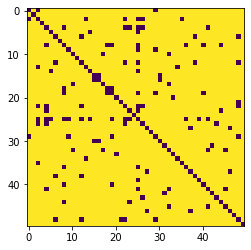

In [86]:
N = 50
distances = euclidean_distance(Y_val[None, :N], Y_val_pred[:N, None])
different = distances + distances.T

distances_diag = torch.diag(distances)
same = distances_diag[None, :] + distances_diag[:, None]

comparison = same < different

plt.imshow(comparison)